# Assessing MLE convergence

In [26]:
import itertools
import jax.numpy as np
import matplotlib.pyplot as plt
from gcdyn import bdms
from gcdyn.model import Model
from jax import jit, grad
from tqdm.auto import tqdm
from collections import namedtuple

## Demo usage of gcdyn module

In [2]:
def plot_curve(*θ_values, range = (-10, 10), **named_θ_values):
    x_array = np.linspace(*range)
    λ = lambda θ: Model.λ(None, x_array, θ)

    plt.figure()

    for θ in θ_values:
        plt.plot(x_array, λ(θ))

    for name, θ in named_θ_values.items():
        plt.plot(x_array, λ(θ), label = name)
    
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\lambda_\theta(x)$")
    plt.xlim(*range)
    
    if named_θ_values:
        plt.legend()

    plt.show()


def build_model(θ, μ = 1, γ = 1, ρ = 0.5, t = 5, n_trees = 5, seed = None):
    trees = [bdms.TreeNode() for _ in range(n_trees)]
    for tree in trees:
        tree.evolve(
            t,
            birth_rate    = bdms.SigmoidResponse(θ[1], θ[2], θ[0], θ[3]),
            death_rate    = bdms.ConstantResponse(1),
            mutation_rate = bdms.ConstantResponse(1),
            mutator       = bdms.GaussianMutator(-1, 1),
            min_survivors = 20,
            seed = seed
        )

    return Model(trees, μ = μ, γ = γ, ρ = ρ)

### Example 1

In [3]:
θ = [2, 1, 0, 0]

model = build_model(θ, seed = 0)

In [4]:
mle = model.fit()
print(f"Solution: {mle.params}")

Solution: [1.6678083  7.1777625  0.24292359 0.35968977]


In [5]:
# Subsequent runs are quicker
model.fit()

OptStep(params=DeviceArray([1.6678083 , 7.1777625 , 0.24292359, 0.35968977], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(951.3538, dtype=float32, weak_type=True), success=True, status=0, iter_num=18))

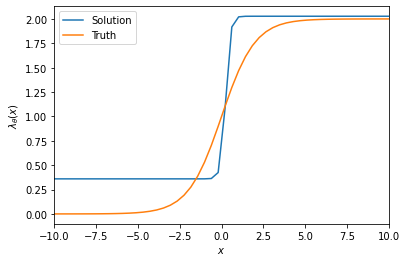

In [6]:
plot_curve(Solution = mle.params, Truth = θ)

### Example 2

In [81]:
θ = [-2, 1, 0, 2]

In [82]:
model = build_model(θ, seed = 0)

In [18]:
mle = model.fit(init_value = θ, lower_bounds = [-np.inf, 0, -np.inf, 0])
print(f"Solution: {mle.params}")

Solution: [-1.6092503   0.32538337  0.6049948   1.975388  ]


In [19]:
# Subsequent runs are quicker
model.fit(init_value = θ, lower_bounds = [-np.inf, 0, -np.inf, 0])

OptStep(params=DeviceArray([-1.6092503 ,  0.32538337,  0.6049948 ,  1.975388  ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(1540.5035, dtype=float32, weak_type=True), success=True, status=0, iter_num=17))

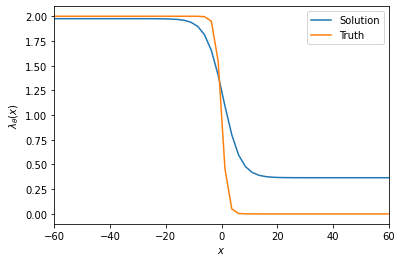

In [21]:
plot_curve(Solution = mle.params, Truth = θ, range = (-60, 60))

## Code to try different initial values for MLE runs

Note that this still assumes a single model with a fixed $θ$; we just try to run the algorithm from different starting points.

In [49]:
def try_init_values(model, true_θ, *search_ranges):
    """
    Runs MLE algorithm for `model` starting from points in the specified range of initial values,
    and plots the resulting log likelihoods against the distance of the initial value from the true parameter value.
    """

    true_θ = np.array(true_θ)

    search_space = itertools.product(*search_ranges)
    search_space = [np.array(t, dtype = float) for t in search_space]

    magnitudes = []
    log_liks = []
    skipped_values = []

    Result = namedtuple("Result", ("θ_init", "θ_result", "magnitude", "log_lik"))
    Result.__repr__ = lambda self: f"θ_init: {self.θ_init}, magnitude: {self.magnitude}, log lik: {self.log_lik}, θ_result: {self.θ_result}"
    results = []

    for θ_init in tqdm(search_space, desc = "Init value #"):
        result = model.fit(init_value = θ_init)
        log_lik = result.state.fun_val

        if np.isnan(log_lik):
            skipped_values.append(θ_init)

        else:
            results.append(Result(
                θ_init    = θ_init,
                θ_result  = result.params,
                magnitude = np.sqrt(np.power(true_θ - θ_init, 2).sum()),
                log_lik   = log_lik
            ))

    magnitudes = np.array([result.magnitude for result in results])
    log_liks = np.array([result.log_lik for result in results])

    plt.scatter(magnitudes, log_liks)
    plt.xlabel(r"$||\theta - \theta\_init||$")
    plt.ylabel("log likelihood of result")
    plt.show()

    if skipped_values:
        print("Note: the following initial values were skipped:")

        for val in skipped_values:
            print(val)

    return results

Init value #:   0%|          | 0/2500 [00:00<?, ?it/s]

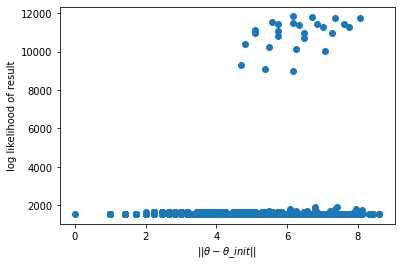

Note: the following initial values were skipped:
[-5.  0. -5.  0.]
[-5.  0. -4.  0.]
[-5.  0. -3.  0.]
[-5.  0. -2.  0.]
[-5.  0. -1.  0.]
[-5.  0.  0.  0.]
[-5.  0.  1.  0.]
[-5.  0.  2.  0.]
[-5.  0.  3.  0.]
[-5.  0.  4.  0.]
[-5.  1. -5.  0.]
[-5.  1. -4.  0.]
[-5.  1. -3.  0.]
[-5.  1. -2.  0.]
[-5.  1. -1.  0.]
[-5.  1.  0.  0.]
[-5.  1.  1.  0.]
[-5.  1.  2.  0.]
[-5.  1.  3.  0.]
[-5.  1.  4.  0.]
[-5.  2. -5.  0.]
[-5.  2. -4.  0.]
[-5.  2. -3.  0.]
[-5.  2. -2.  0.]
[-5.  2. -1.  0.]
[-5.  2.  0.  0.]
[-5.  2.  1.  0.]
[-5.  2.  2.  0.]
[-5.  2.  3.  0.]
[-5.  2.  4.  0.]
[-5.  3. -5.  0.]
[-5.  3. -4.  0.]
[-5.  3. -3.  0.]
[-5.  3. -2.  0.]
[-5.  3. -1.  0.]
[-5.  3.  0.  0.]
[-5.  3.  1.  0.]
[-5.  3.  2.  0.]
[-5.  3.  3.  0.]
[-5.  3.  4.  0.]
[-5.  4. -5.  0.]
[-5.  4. -4.  0.]
[-5.  4. -3.  0.]
[-5.  4. -2.  0.]
[-5.  4. -1.  0.]
[-5.  4.  0.  0.]
[-5.  4.  1.  0.]
[-5.  4.  2.  0.]
[-5.  4.  3.  0.]
[-5.  4.  4.  0.]
[-4.  0. -5.  0.]
[-4.  0. -4.  0.]
[-4.  0. -3.  0

In [50]:
results = try_init_values(model, θ, range(-5, 5), range(0, 5), range(-5, 5), range(0, 5))

In [56]:
for bad_result in sorted(results, key = lambda result: -result.log_lik)[0:20]:
    print(
        bad_result.θ_init, 
        bad_result.θ_result,
        np.all(bad_result.θ_init == bad_result.θ_result)
    )

[1. 4. 4. 0.] [1. 4. 4. 0.] True
[2. 4. 4. 0.] [2. 4. 4. 0.] True
[3. 4. 4. 0.] [3. 4. 4. 0.] True
[4. 4. 4. 0.] [4. 4. 4. 0.] True
[1. 4. 3. 0.] [1. 4. 3. 0.] True
[2. 4. 3. 0.] [2. 4. 3. 0.] True
[3. 4. 3. 0.] [3. 4. 3. 0.] True
[1. 3. 4. 0.] [1. 3. 4. 0.] True
[4. 4. 3. 0.] [4. 4. 3. 0.] True
[2. 3. 4. 0.] [2. 3. 4. 0.] True
[3. 3. 4. 0.] [3. 3. 4. 0.] True
[4. 3. 4. 0.] [4. 3. 4. 0.] True
[1. 4. 2. 0.] [1. 4. 2. 0.] True
[2. 4. 2. 0.] [2. 4. 2. 0.] True
[3. 4. 2. 0.] [3. 4. 2. 0.] True
[1. 3. 3. 0.] [1. 3. 3. 0.] True
[4. 4. 2. 0.] [4. 4. 2. 0.] True
[2. 3. 3. 0.] [2. 3. 3. 0.] True
[3. 3. 3. 0.] [3. 3. 3. 0.] True
[1. 4. 1. 0.] [1. 4. 1. 0.] True


In [59]:
for good_result in sorted(results, key = lambda result: result.log_lik)[0:20]:
    print(
        good_result.θ_init,
        "\t\t",
        good_result.θ_result
    )

[-5.  1. -5.  1.] 		 [ 0.         0.9705699 -4.991949   1.6606375]
[-4.  1. -5.  1.] 		 [ 0.         0.9705699 -4.991949   1.6606375]
[-3.  1. -5.  1.] 		 [ 0.         0.9705699 -4.991949   1.6606375]
[-2.  1. -5.  1.] 		 [ 0.         0.9705699 -4.991949   1.6606375]
[-1.  1. -5.  1.] 		 [ 0.         0.9705699 -4.991949   1.6606375]
[ 0.  1. -5.  1.] 		 [ 0.         0.9705699 -4.991949   1.6606375]
[2. 0. 3. 1.] 		 [1.8624334  0.         3.0117123  0.72673583]
[ 3.  4. -3.  3.] 		 [3.3964107 4.1155796 5.2843776 1.6579571]
[ 1.  4. -5.  4.] 		 [1.5597008 3.8476574 9.894081  1.6575811]
[ 4.  3. -5.  4.] 		 [5.3011155 2.9562597 5.6077952 1.6575811]
[2. 0. 3. 0.] 		 [2.2635157  0.         3.         0.52703154]
[ 4.  3. -4.  0.] 		 [ 0.         2.6884677 -2.6037796  1.6575809]
[ 4.  4. -5.  3.] 		 [5.442532  3.7341104 9.366478  1.6553754]
[1. 3. 0. 0.] 		 [0.        3.0368536 0.934958  1.6575863]
[3. 0. 4. 1.] 		 [2.3594272  0.         4.16777    0.47787344]
[ 4.  4. -1.  4.] 		 [3.790844 

## MLE on BEAST trees

In [64]:
import pickle

with open("tenseqs_subset-ete3_trees.pickle", "rb") as trees_file:
    beast_trees = pickle.load(trees_file)

In [76]:
some_trees = list(beast_trees.values())[90:]
model = Model(some_trees, μ = 1, γ = 1, ρ = 0.5)

In [77]:
mle = model.fit()

OptStep(params=DeviceArray([2.0616806 , 1.2297031 , 2.3062227 , 0.00948923], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(2687.0386, dtype=float32, weak_type=True), success=True, status=0, iter_num=4))


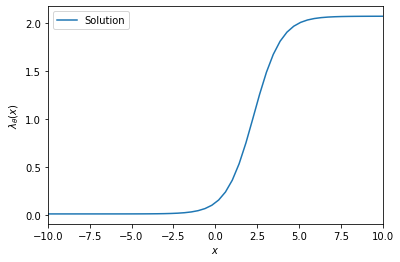

In [79]:
print(mle)

plot_curve(Solution = mle.params)